In [1]:
from datasets.get_datasets import *
from revision import *
from boostsrl import boostsrl
import random
from sklearn.model_selection import KFold
import numpy as np

In [2]:
target = 'advisedby'
validation_size = 0.1
max_revision_iterations = 10

In [3]:
[facts, pos, neg] = get_uwcse_dataset(target, acceptedPredicates=[
'professor',
'student',
'advisedby',
'tempadvisedby',
'ta',
'hasposition',
'publication',
'inphase',
'courselevel',
'yearsinprogram',
'projectmember',
])

In [4]:
bk = ['professor(+person).',
'student(+person).',
'advisedby(+person,+person).',
'advisedby(+person,-person).',
'advisedby(-person,+person).',
'tempadvisedby(+person,+person).',
'tempadvisedby(+person,-person).',
'tempadvisedby(-person,+person).',
'ta(+course,+person,+quarter).',
'ta(-course,+person,+quarter).',
'ta(+course,-person,+quarter).',
'ta(+course,+person,-quarter).',
'ta(-course,+person,-quarter).',
'ta(+course,-person,-quarter).',
'hasposition(+person,+faculty).',
'hasposition(+person,-faculty).',
'hasposition(-person,+faculty).',
'publication(+title,+person).',
'publication(+title,-person).',
'publication(-title,+person).',
'inphase(+person,+prequals).',
'inphase(+person,-prequals).',
'inphase(-person,+prequals).',
'courselevel(+course,+level).',
'courselevel(+course,-level).',
'courselevel(-course,+level).',
'yearsinprogram(+person,+year).',
'yearsinprogram(-person,+year).',
'yearsinprogram(+person,-year).',
'projectmember(+project,+person).',
'projectmember(+project,-person).',
'projectmember(-project,+person).']
#'sameproject(project, project).',
#'samecourse(course, course).',
#'sameperson(person, person).',]

background = boostsrl.modes(bk, [target], useStdLogicVariables=False, treeDepth=8, nodeSize=3, numOfClauses=8)

In [80]:
import sys
import time

# shuffle all examples
random.shuffle(pos)
random.shuffle(neg)

neg = neg[:len(pos)] # balanced

import numpy as np
pos = np.array(pos)
neg = np.array(neg)

small_dataset_aucroc = {}
complete_dataset_aucroc = []
revision_dataset_aucroc = {}

revisions = 6
smalls = 4

for small_train_size in np.linspace(0.25, 1.0, num=smalls):
    small_dataset_aucroc[str(small_train_size)] = []
    revision_dataset_aucroc[str(small_train_size)] = {}
    for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
        revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)] = []

start = time.time()
# separate train and test
kf = KFold(n_splits=10)
fold = 0
for train_index, test_index in kf.split(pos):
    train_pos, test_pos = pos[train_index], pos[test_index]
    train_neg, test_neg = neg[train_index], neg[test_index]
    fold += 1
    
    # shuffle all train examples
    random.shuffle(train_pos)
    random.shuffle(train_neg)
        
    # train set used in revision and validation set
    r_train_pos = train_pos[int(validation_size*len(train_pos)):]
    r_train_neg = train_neg[int(validation_size*len(train_neg)):]
    validation_pos = train_pos[:int(validation_size*len(train_pos))]
    validation_neg = train_neg[:int(validation_size*len(train_neg))]
    
    '''print('New fold')
    print('train_pos: '+str(len(train_pos)))
    print('test_pos: '+str(len(test_pos)))
    print('r_train_pos: '+str(len(r_train_pos)))
    print('validation_pos: '+str(len(validation_pos)))
    print('\n')'''

    # learning from complete dataset
    #[model, learning_time, inference_time, t_results, structured] = learn_test_model(background, boostsrl, target, r_train_pos, r_train_neg, facts, test_pos, test_neg, trees=1, verbose=False)
    #complete_dataset_aucroc.append(t_results['AUC ROC'])

    for small_train_size in np.linspace(0.25, 1.0, num=smalls): #num=4):
        # learn from scratch in a small dataset
        s_train_pos = r_train_pos[:int(small_train_size*len(r_train_pos))]
        s_train_neg = r_train_neg[:int(small_train_size*len(r_train_neg))]
        
        '''print('New small dataset')
        print('s_train_pos: '+str(len(s_train_pos)))
        print(s_train_pos)
        print('\n')'''

        # learning from small dataset
        [model, learning_time, inference_time, t_results, small_structured] = learn_test_model(background, boostsrl, target, s_train_pos, s_train_neg, facts, test_pos, test_neg, trees=1, verbose=False)
        small_dataset_aucroc[str(small_train_size)].append(t_results['AUC ROC'])

        for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
            # theory revision
            [model, total_revision_time, inference_time, t_results, structured] = theory_revision(background, boostsrl, target, r_train_pos, r_train_neg, facts, validation_pos, validation_neg, test_pos, test_neg, revision_threshold, small_structured.copy(), max_revision_iterations=10, verbose=False)
            revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)].append(t_results['AUC ROC'])
            #print('aaa')
            sys.stdout.write('\rFold: %s, small_train_size: %s, revision_threshold: %s, time: %s' % (fold, small_train_size, revision_threshold, time.strftime('%H:%M:%S', time.gmtime(time.time()-start))))
            sys.stdout.flush()

Fold: 10, small_train_size: 1.0, revision_threshold: 1.0, time: 00:32:45

In [81]:
#import json
#file = open('curve.json', 'w')
#file.write(json.dumps([small_dataset_aucroc, complete_dataset_aucroc, revision_dataset_aucroc]))
#file.close()

## Learning 1 tree
## Revision thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
## Target: advisedby

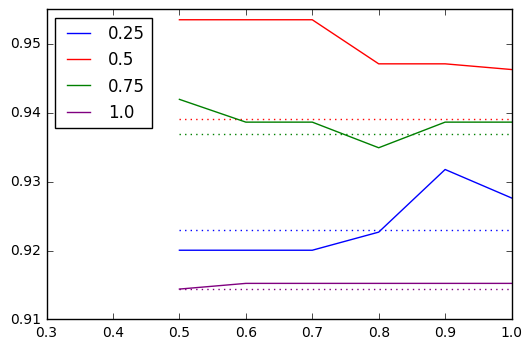

In [83]:
import matplotlib.pyplot as plt
colors = {'0.25': 'blue', '0.5': 'red', '0.75': 'green', '1.0': 'purple'}
for small_train_size in np.linspace(0.25, 1.0, num=smalls):
    x = []
    y = []
    base = np.array(small_dataset_aucroc[str(small_train_size)])
    base = base.mean()
    base = revisions * [base]
    for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
        x.append(revision_threshold)
        v = revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)]
        v = np.array(v)
        y.append(v.mean())
    plt.plot(x, y, label=str(small_train_size), color=colors[str(small_train_size)])
    plt.plot(x, base, linestyle=':', color=colors[str(small_train_size)])
plt.xlim(0.3,1.0)
plt.legend(loc='upper left')
plt.show()

In [84]:
import sys
import time

# shuffle all examples
random.shuffle(pos)
random.shuffle(neg)

neg = neg[:len(pos)] # balanced

import numpy as np
pos = np.array(pos)
neg = np.array(neg)

small_dataset_aucroc = {}
complete_dataset_aucroc = []
revision_dataset_aucroc = {}

revisions = 11
smalls = 4

for small_train_size in np.linspace(0.25, 1.0, num=smalls):
    small_dataset_aucroc[str(small_train_size)] = []
    revision_dataset_aucroc[str(small_train_size)] = {}
    for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
        revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)] = []

start = time.time()
# separate train and test
kf = KFold(n_splits=10)
fold = 0
for train_index, test_index in kf.split(pos):
    train_pos, test_pos = pos[train_index], pos[test_index]
    train_neg, test_neg = neg[train_index], neg[test_index]
    fold += 1
    
    # shuffle all train examples
    random.shuffle(train_pos)
    random.shuffle(train_neg)
        
    # train set used in revision and validation set
    r_train_pos = train_pos[int(validation_size*len(train_pos)):]
    r_train_neg = train_neg[int(validation_size*len(train_neg)):]
    validation_pos = train_pos[:int(validation_size*len(train_pos))]
    validation_neg = train_neg[:int(validation_size*len(train_neg))]
    
    '''print('New fold')
    print('train_pos: '+str(len(train_pos)))
    print('test_pos: '+str(len(test_pos)))
    print('r_train_pos: '+str(len(r_train_pos)))
    print('validation_pos: '+str(len(validation_pos)))
    print('\n')'''

    # learning from complete dataset
    #[model, learning_time, inference_time, t_results, structured] = learn_test_model(background, boostsrl, target, r_train_pos, r_train_neg, facts, test_pos, test_neg, trees=1, verbose=False)
    #complete_dataset_aucroc.append(t_results['AUC ROC'])

    for small_train_size in np.linspace(0.25, 1.0, num=smalls): #num=4):
        # learn from scratch in a small dataset
        s_train_pos = r_train_pos[:int(small_train_size*len(r_train_pos))]
        s_train_neg = r_train_neg[:int(small_train_size*len(r_train_neg))]
        
        '''print('New small dataset')
        print('s_train_pos: '+str(len(s_train_pos)))
        print(s_train_pos)
        print('\n')'''

        # learning from small dataset
        [model, learning_time, inference_time, t_results, small_structured] = learn_test_model(background, boostsrl, target, s_train_pos, s_train_neg, facts, test_pos, test_neg, trees=1, verbose=False)
        small_dataset_aucroc[str(small_train_size)].append(t_results['AUC ROC'])

        for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
            # theory revision
            [model, total_revision_time, inference_time, t_results, structured] = theory_revision(background, boostsrl, target, r_train_pos, r_train_neg, facts, validation_pos, validation_neg, test_pos, test_neg, revision_threshold, small_structured.copy(), max_revision_iterations=10, verbose=False)
            revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)].append(t_results['AUC ROC'])
            #print('aaa')
            sys.stdout.write('\rFold: %s, small_train_size: %s, revision_threshold: %s, time: %s' % (fold, small_train_size, revision_threshold, time.strftime('%H:%M:%S', time.gmtime(time.time()-start))))
            sys.stdout.flush()

Fold: 10, small_train_size: 1.0, revision_threshold: 1.0, time: 00:51:27

## Learning 1 tree
## Revision thresholds = [0.5,0.55,0.6...,1.0]
## Target: advisedby

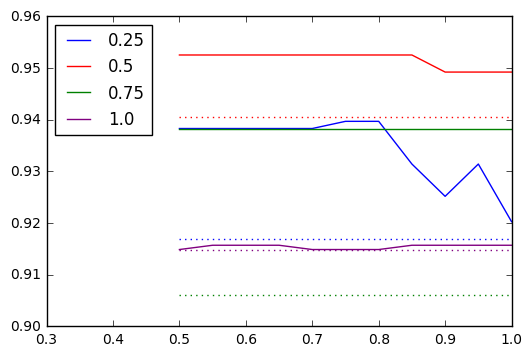

In [85]:
import matplotlib.pyplot as plt
colors = {'0.25': 'blue', '0.5': 'red', '0.75': 'green', '1.0': 'purple'}
for small_train_size in np.linspace(0.25, 1.0, num=smalls):
    x = []
    y = []
    base = np.array(small_dataset_aucroc[str(small_train_size)])
    base = base.mean()
    base = revisions * [base]
    for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
        x.append(revision_threshold)
        v = revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)]
        v = np.array(v)
        y.append(v.mean())
    plt.plot(x, y, label=str(small_train_size), color=colors[str(small_train_size)])
    plt.plot(x, base, linestyle=':', color=colors[str(small_train_size)])
plt.xlim(0.3,1.0)
plt.legend(loc='upper left')
plt.show()

In [99]:
import sys
import time

# shuffle all examples
random.shuffle(pos)
random.shuffle(neg)

neg = neg[:len(pos)] # balanced

import numpy as np
pos = np.array(pos)
neg = np.array(neg)

small_dataset_aucroc = {}
small_dataset_aucpr = {}
revision_dataset_aucroc = {}
revision_dataset_aucpr = {}

revisions = 6
smalls = 4

for small_train_size in np.linspace(0.25, 1.0, num=smalls):
    small_dataset_aucroc[str(small_train_size)] = []
    small_dataset_aucpr[str(small_train_size)] = []
    revision_dataset_aucroc[str(small_train_size)] = {}
    revision_dataset_aucpr[str(small_train_size)] = {}
    for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
        revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)] = []
        revision_dataset_aucpr[str(small_train_size)][str(revision_threshold)] = []

start = time.time()
# separate train and test
kf = KFold(n_splits=10)
fold = 0
for train_index, test_index in kf.split(pos):
    train_pos, test_pos = pos[train_index], pos[test_index]
    train_neg, test_neg = neg[train_index], neg[test_index]
    fold += 1
    
    # shuffle all train examples
    random.shuffle(train_pos)
    random.shuffle(train_neg)
        
    # train set used in revision and validation set
    r_train_pos = train_pos[int(validation_size*len(train_pos)):]
    r_train_neg = train_neg[int(validation_size*len(train_neg)):]
    validation_pos = train_pos[:int(validation_size*len(train_pos))]
    validation_neg = train_neg[:int(validation_size*len(train_neg))]
    
    '''print('New fold')
    print('train_pos: '+str(len(train_pos)))
    print('test_pos: '+str(len(test_pos)))
    print('r_train_pos: '+str(len(r_train_pos)))
    print('validation_pos: '+str(len(validation_pos)))
    print('\n')'''

    # learning from complete dataset
    #[model, learning_time, inference_time, t_results, structured] = learn_test_model(background, boostsrl, target, r_train_pos, r_train_neg, facts, test_pos, test_neg, trees=1, verbose=False)
    #complete_dataset_aucroc.append(t_results['AUC ROC'])

    for small_train_size in np.linspace(0.25, 1.0, num=smalls): #num=4):
        # learn from scratch in a small dataset
        s_train_pos = r_train_pos[:int(small_train_size*len(r_train_pos))]
        s_train_neg = r_train_neg[:int(small_train_size*len(r_train_neg))]
        
        '''print('New small dataset')
        print('s_train_pos: '+str(len(s_train_pos)))
        print(s_train_pos)
        print('\n')'''

        # learning from small dataset
        [model, learning_time, inference_time, t_results, small_structured] = learn_test_model(background, boostsrl, target, s_train_pos, s_train_neg, facts, test_pos, test_neg, trees=10, verbose=False)
        small_dataset_aucroc[str(small_train_size)].append(t_results['AUC ROC'])
        small_dataset_aucpr[str(small_train_size)].append(t_results['AUC PR'])

        for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
            # theory revision
            [model, total_revision_time, inference_time, t_results, structured] = theory_revision(background, boostsrl, target, r_train_pos, r_train_neg, facts, validation_pos, validation_neg, test_pos, test_neg, revision_threshold, small_structured.copy(), max_revision_iterations=10, verbose=False)
            revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)].append(t_results['AUC ROC'])
            revision_dataset_aucpr[str(small_train_size)][str(revision_threshold)].append(t_results['AUC PR'])
            #print('aaa')
            sys.stdout.write('\rFold: %s, small_train_size: %s, revision_threshold: %s, time: %s' % (fold, small_train_size, revision_threshold, time.strftime('%H:%M:%S', time.gmtime(time.time()-start))))
            sys.stdout.flush()

Fold: 10, small_train_size: 1.0, revision_threshold: 1.0, time: 00:40:35

## Learning 10 boosted trees
## Revision threshold = 0.5,0.6,...,1.0
## target: advisedby

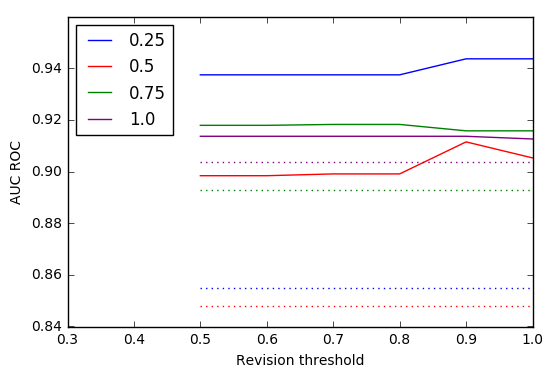

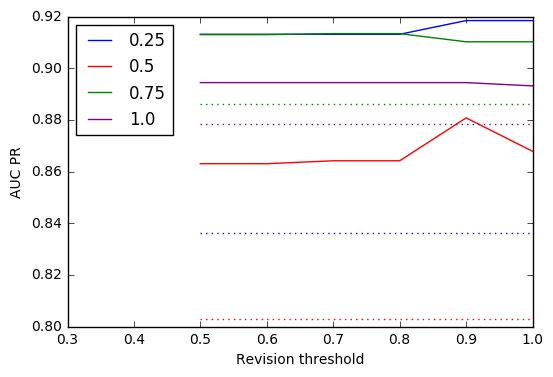

In [100]:
import matplotlib.pyplot as plt
colors = {'0.25': 'blue', '0.5': 'red', '0.75': 'green', '1.0': 'purple'}
for small_train_size in np.linspace(0.25, 1.0, num=smalls):
    x = []
    y = []
    base = np.array(small_dataset_aucroc[str(small_train_size)])
    base = base.mean()
    base = revisions * [base]
    for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
        x.append(revision_threshold)
        v = revision_dataset_aucroc[str(small_train_size)][str(revision_threshold)]
        v = np.array(v)
        y.append(v.mean())
    plt.plot(x, y, label=str(small_train_size), color=colors[str(small_train_size)])
    plt.plot(x, base, linestyle=':', color=colors[str(small_train_size)])
plt.xlim(0.3,1.0)
plt.xlabel('Revision threshold')
plt.ylabel('AUC ROC')
plt.legend(loc='upper left')
plt.show()

for small_train_size in np.linspace(0.25, 1.0, num=smalls):
    x = []
    y = []
    base = np.array(small_dataset_aucpr[str(small_train_size)])
    base = base.mean()
    base = revisions * [base]
    for revision_threshold in np.linspace(0.5, 1.0, num=revisions):
        x.append(revision_threshold)
        v = revision_dataset_aucpr[str(small_train_size)][str(revision_threshold)]
        v = np.array(v)
        y.append(v.mean())
    plt.plot(x, y, label=str(small_train_size), color=colors[str(small_train_size)])
    plt.plot(x, base, linestyle=':', color=colors[str(small_train_size)])
plt.xlim(0.3,1.0)
plt.xlabel('Revision threshold')
plt.ylabel('AUC PR')
plt.legend(loc='upper left')
plt.show()